# MCP Servers: Connecting LLMs to External Services

In the previous notebook, we created a simple calculator tool directly in Python. But what if we want to connect to external services, databases, or APIs?

This is where **Model Context Protocol (MCP)** comes in. MCP is a standard protocol that allows LLMs to interact with external tools and services in a structured way.

In this notebook, we'll:
1. Explore the Calendar API and Frontend
2. Make direct API calls
3. Connect to an MCP Server
4. Build an agent that uses MCP tools

Let's get started! 🚀

## 1. Exploring the Calendar Application

First, let's check out the deployed calendar application. It consists of:
- **Frontend**: A React web UI for managing calendar events
- **API**: A FastAPI backend that stores events in a database
- **MCP Server**: An MCP-compliant interface to the API

Let's start looking at the API, as the MCP simply will be a communication layer between the LLM and that API.

The Calendar API is a REST API with the following endpoints:

| Method | Endpoint | Description |
|--------|----------|-------------|
| GET | `/schedules` | Get all calendar events |
| GET | `/schedules/{id}` | Get a specific event |
| POST | `/schedules` | Create a new event |
| PUT | `/schedules/{id}` | Update an event |
| DELETE | `/schedules/{id}` | Delete an event |

Each event has this structure:
```json
{
  "sid": "unique-id",
  "name": "Event Name",
  "content": "Description",
  "category": "Lecture|Lab|Meeting|...",
  "level": 1-3,  // Priority
  "status": 0.0-1.0,  // Completion %
  "start_time": "YYYY-MM-DD HH:MM:SS",
  "end_time": "YYYY-MM-DD HH:MM:SS",
  "creation_time": "YYYY-MM-DD HH:MM:SS"
}
```

## 3. Making Direct API Calls

Let's interact with the Calendar API directly using Python's `requests` library:

In [ ]:
#Disable some logs
import logging

logging.getLogger("httpx").setLevel(logging.WARNING)
logging.getLogger().setLevel(logging.WARNING)

In [ ]:
calendar_api_url = "http://canopy-mcp-calendar-api:8000"

In [ ]:
import requests
import json
from datetime import datetime, timedelta

# Get all events from the /schedules endpoint
print("📋 Getting all events...")
response = requests.get(f"{calendar_api_url}/schedules")
events = response.json()


# Print the events
print(f"Found {len(events)} events:\n")
for event in events[:5]:  # Show first 5
    print(f"  • {event['name']} ({event['category']})")
    print(f"    📅 {event['start_time']} → {event['end_time']}")
    print(f"    ✅ {int(event.get('status', 0) * 100)}% complete\n")

if len(events) > 5:
    print(f"... and {len(events) - 5} more events")

Great, we have some events already, let's add another one!  
After you have added it, make sure to check in the calendar UI to verify for yourself that it did get added.

In [ ]:
# Create a new event
print("Creating a new event...")

event_name = "AI Workshop: Introduction to Agents"
tomorrow = datetime.now() + timedelta(days=1)
start_time = tomorrow.replace(hour=14, minute=0, second=0)
end_time = start_time + timedelta(hours=1, minutes=30)

new_event = {
    "sid": f"notebook-test-{int(datetime.now().timestamp())}",
    "name": event_name,
    "content": "Learn how to build AI agents using LLMs and tools",
    "category": "Workshop",
    "level": 2,
    "status": 0.0,
    "creation_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "start_time": start_time.strftime("%Y-%m-%d %H:%M:%S"),
    "end_time": end_time.strftime("%Y-%m-%d %H:%M:%S")
}

response = requests.post(f"{calendar_api_url}/schedules", json=new_event)

if response.status_code == 200:
    created_event = response.json()
    print(f"✅ Event created successfully!")
    print(f"   ID: {created_event['sid']}")
    print(f"   Name: {created_event['name']}")
    print(f"   Time: {created_event['start_time']} → {created_event['end_time']}")
else:
    print(f"❌ Error: {response.status_code} - {response.text}")

## 4. Connecting to the MCP Server

Now let's connect to the **MCP Server**. Unlike the direct API calls above, MCP provides a standardized way for LLMs to discover and use tools.

The MCP server wraps the Calendar API and exposes it as **9 structured tools** that an LLM can use:

1. `get_all_events` - Get all events with optional filtering
2. `get_event` - Get a specific event by ID
3. `create_event` - Create a new event
4. `update_event` - Update an existing event
5. `delete_event` - Delete an event
6. `search_events` - Search by name/content
7. `get_upcoming_events` - Get events in the next N days
8. `get_events_by_date` - Get events for a specific date
9. `get_calendar_statistics` - Get calendar stats

Let's connect!

In [ ]:
# Install MCP SDK
!pip3 install -q mcp httpx

In [ ]:
from mcp import ClientSession
from mcp.client.sse import sse_client

# Connect to the MCP server
mcp_server_url = "http://canopy-mcp-calendar-mcp-server:8080/sse"
print(f"🔌 Connecting to MCP server at {mcp_server_url}...")

# We'll use this in the next cells
mcp_session = None

### Listing Available MCP Tools

Let's see what tools the MCP server provides. This is one of the key features of MCP - **tool discovery**!

In [ ]:
import asyncio

async def list_mcp_tools():
    """Connect to MCP server and list available tools."""
    async with sse_client(mcp_server_url) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            print("✅ Connected to MCP server!\n")
            
            # List available tools
            tools = await session.list_tools() # 👈 This is how we call the MCP functions and tools
            print(f"📋 Found {len(tools.tools)} MCP tools:\n")
            print("---")
            
            for i, tool in enumerate(tools.tools, 1):
                print(f"{i}. {tool.name}")
                print(f"   {tool.description}")
                print("---")
            
            return session

# Run the async function
await list_mcp_tools()

### Calling MCP Tools Directly

Now let's call some MCP tools to see how they work:

In [ ]:
async def call_mcp_tool_example():
    """Example: Call get_upcoming_events tool."""
    async with sse_client(mcp_server_url) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            
            # Call the get_upcoming_events tool
            print("📅 Calling MCP tool: get_upcoming_events")
            print("   Arguments: {'days': 7}\n")
            
            result = await session.call_tool(
                "get_upcoming_events",  # 👈 The tool we want to call
                arguments={"days": 7}   # 👈 The arguments we want to send the tool (see list in last cell for all arguments)
            )
            
            print("Result:")
            print("-" * 60)
            for content in result.content:
                print(content.text)
            print("-" * 60)

await call_mcp_tool_example()

In [ ]:
async def search_events_example():
    """Example: Search for events containing 'lecture'."""
    async with sse_client(mcp_server_url) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            
            # Search for events
            print("🔍 Calling MCP tool: search_events")
            print("   Arguments: {'query': 'lecture'}\n")
            
            result = await session.call_tool(
                "search_events",
                arguments={"query": "lecture"}
            )
            
            print("Result:")
            print("-" * 60)
            for content in result.content:
                print(content.text)
            print("-" * 60)

await search_events_example()

## 5. Building an Agent with MCP

So far we have simply been sending direct request to either the API or the MCP Server, let's introduce the LLM just like in the previous notebook (`1-intro-to-tools.ipynb`).  

This will be similar to what we did with the calculator, but now we're using a real external service through MCP.  
However, we are adding one more important twist - we are letting the LLM choose what tools to use!  
We can do this fairly simply by just giving the LLM the list of tools available and asking it to choose which is best to use and then create the json input for that specific tool.  
This gives us a **lot** more flexibility and agency with our agents 🤖

### Setting up the LLM

In [ ]:
!pip3 install -q llama-stack-client==0.3.0

In [ ]:
from llama_stack_client import LlamaStackClient
from llama_stack_client.lib.inference.event_logger import EventLogger

# Connect to Llama Stack Server
base_url = "http://llama-stack-service:8321"
llm_client = LlamaStackClient(base_url=base_url)
llm_model = "llama32"

print(f"Connected to Llama Stack at: {base_url}")
print(f"Using model: {llm_model}")

### Step-by-Step Agent Walkthrough

Now let's build an agent that can understand natural language (plain text) requests and automatically call MCP tools!

We'll walk through each step individually so you can see the inputs and outputs clearly.

**Step 1: Define the user request**

In [ ]:
# This is what the user asks
user_request = "What events do I have coming up in the next 3 days?"

print("USER REQUEST:")
print(user_request)

**Step 2: Get MCP tool descriptions**

We need to get the available MCP tools and their descriptions to include in the system prompt:

In [ ]:
async def get_mcp_tools_description():
    """Get descriptions of all available MCP tools."""
    async with sse_client(mcp_server_url) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            tools = await session.list_tools()
            
            tools_description = ""
            for tool in tools.tools:
                tools_description += f"- {tool.name}: {tool.description}\n"
            
            return tools_description, session

# Get the tool descriptions
mcp_tools_description = await get_mcp_tools_description()

print("AVAILABLE MCP TOOLS:")
print(mcp_tools_description[0])

**Step 3: Create a system prompt with the tool descriptions**

In [ ]:
# Build the system prompt dynamically using the MCP tool descriptions
system_prompt = f"""You are a helpful assistant that converts natural language requests into MCP tool calls.

Available MCP tools:
{mcp_tools_description[0]}

When the user asks you to do something related to calendar events, respond with a JSON object specifying:
1. "tool_name": the name of the MCP tool to call
2. "arguments": a dictionary of arguments for that tool

Respond with ONLY the JSON object. Do not include any explanation.

Example format:
{{
    "tool_name": "get_upcoming_events",
    "arguments": {{"days": 7}}
}}
"""

print("SYSTEM PROMPT:")
print(system_prompt)

**Step 4: Send the request to the LLM to generate a tool call**

In [ ]:
# Ask the LLM to convert the natural language request into an MCP tool call
response = llm_client.chat.completions.create(
    model=llm_model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_request}
    ],
    stream=False,
)

# Extract the LLM's response
llm_response = response.choices[0].message.content

print("USER REQUEST:")
print(user_request)
print()
print("LLM RESPONSE:")
print(llm_response)

**Step 5: Parse the LLM response and call the MCP tool**

In [ ]:
# Clean up the response (sometimes LLMs wrap JSON in markdown code blocks)
cleaned_response = llm_response.strip()
if cleaned_response.startswith("```"):
    # Remove markdown code block markers
    lines = cleaned_response.split("\n")
    cleaned_response = "\n".join(lines[1:-1])
    if cleaned_response.startswith("json"):
        cleaned_response = cleaned_response[4:].strip()

# Parse the JSON
tool_call = json.loads(cleaned_response)
tool_name = tool_call["tool_name"]
tool_arguments = tool_call["arguments"]

print(f"TOOL TO CALL: {tool_name}")
print(f"ARGUMENTS: {json.dumps(tool_arguments, indent=2)}")

# Now call the MCP tool
async def call_mcp_tool(tool_name, arguments):
    async with sse_client(mcp_server_url) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            result = await session.call_tool(tool_name, arguments=arguments)
            return result

mcp_result = await call_mcp_tool(tool_name, tool_arguments)

print("\nMCP TOOL RESULT:")
print("-" * 60)
for content in mcp_result.content:
    print(content.text)
print("-" * 60)

**Step 6: Send the result back to the LLM for interpretation**

In [ ]:
# Extract text from MCP result
result_text = "\n".join([content.text for content in mcp_result.content])

# Ask the LLM to answer the user's question with the tool result
interpretation_prompt = f"""User question: {user_request}
MCP Tool result: {result_text}

Answer the user's question directly with the result. Be concise and friendly."""

response = llm_client.chat.completions.create(
    model=llm_model,
    messages=[
        {"role": "system", "content": "You are a helpful assistant. Answer user questions directly and concisely."},
        {"role": "user", "content": interpretation_prompt}
    ],
    stream=True,
)

print("FINAL RESPONSE TO USER:")
print("-" * 60)
for log in EventLogger().log(response):
    log.print()
print("-" * 60)

All in all, the flow looks something like this:  
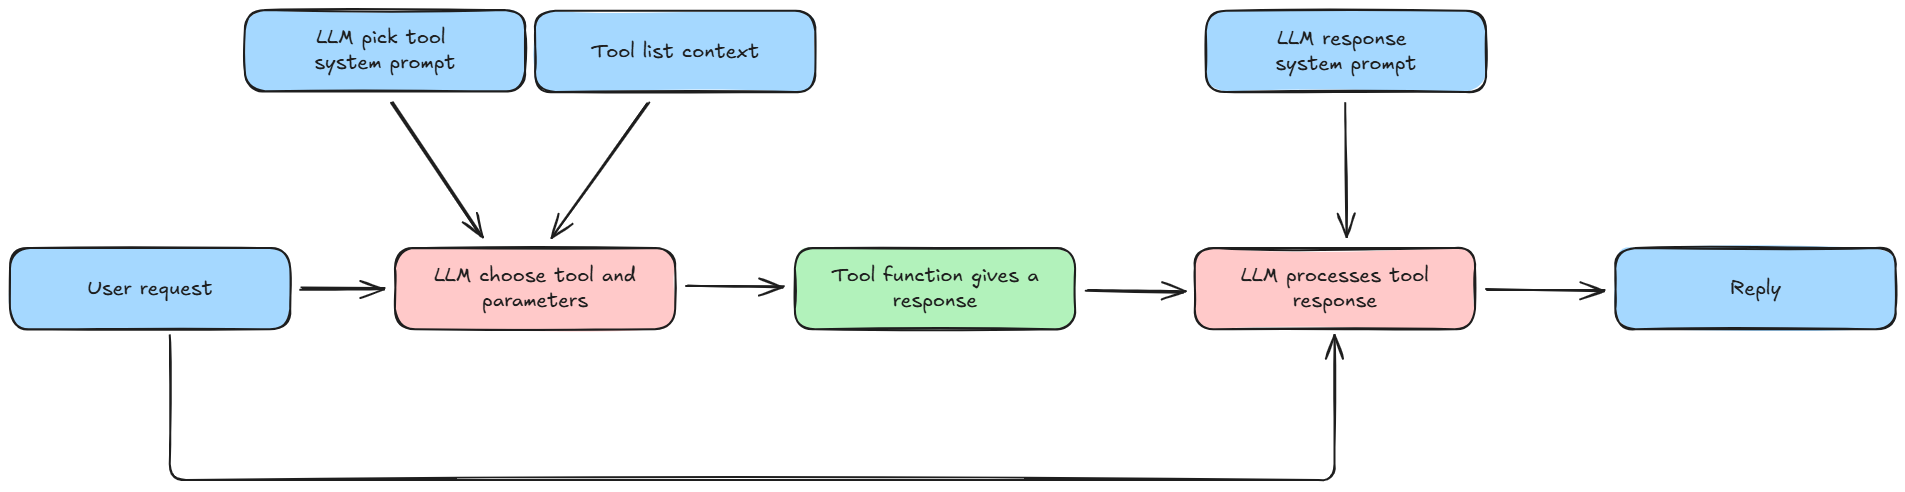

### Complete MCP Agent Function

Now that you've seen each step individually, let's wrap it all into a reusable function that does everything in one go!

This is our simple agentic workflow that automatically:
1. Interprets user requests
2. Calls the appropriate MCP tool
3. Returns the results in natural language

In [ ]:
async def run_mcp_agent(user_request: str):
    """
    Complete MCP agent flow:
    1. User makes a natural language request
    2. LLM interprets and formats as MCP tool call
    3. MCP tool executes
    4. LLM interprets results and responds to user
    """
    print("="*60)
    print(f"USER REQUEST: {user_request}")
    print("="*60)

    # Step 1: Get MCP tools description
    print("\n[Step 1] Getting MCP tools...")
    async with sse_client(mcp_server_url) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            tools = await session.list_tools()
            
            tools_description = ""
            for tool in tools.tools:
                tools_description += f"- {tool.name}: {tool.description}\n"
            
            # Step 2: Use the system prompt from above
            system_prompt = f"""You are a helpful assistant that converts natural language requests into MCP tool calls.

Available MCP tools:
{mcp_tools_description[0]}

When the user asks you to do something related to calendar events, respond with a JSON object specifying:
1. "tool_name": the name of the MCP tool to call
2. "arguments": a dictionary of arguments for that tool

Respond with ONLY the JSON object. Do not include any explanation.

Example format:
{{
    "tool_name": "get_upcoming_events",
    "arguments": {{"days": 7}}
}}
"""

            # Step 3: LLM formats the tool call
            print("\n[Step 2] LLM interpreting User request...")
            response = llm_client.chat.completions.create(
                model=llm_model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_request}
                ],
                stream=False,
            )

            llm_response = response.choices[0].message.content

            print(llm_response)

            # Step 4: Parse the response
            try:
                cleaned_response = llm_response.strip()
                if cleaned_response.startswith("```"):
                    lines = cleaned_response.split("\n")
                    cleaned_response = "\n".join(lines[1:-1])
                    if cleaned_response.startswith("json"):
                        cleaned_response = cleaned_response[4:].strip()

                tool_call = json.loads(cleaned_response)
                tool_name = tool_call["tool_name"]
                tool_arguments = tool_call["arguments"]
            except json.JSONDecodeError as e:
                print(f"Error parsing LLM response: {e}")
                print(f"LLM response was: {llm_response}")
                return

            print("\n[Step 3] Generated MCP Tool Call:")
            print(f"Tool: {tool_name}")
            print(f"Arguments: {json.dumps(tool_arguments, indent=2)}")

            # Step 5: Execute the MCP tool
            print("\n[Step 4] Calling MCP tool... MCP Tool Result:")
            mcp_result = await session.call_tool(tool_name, arguments=tool_arguments)
            
            result_text = "\n".join([content.text for content in mcp_result.content])
            print(result_text[:200] + "..." if len(result_text) > 200 else result_text)

            # Step 6: LLM interprets the result
            print("\n[Step 5] LLM interpreting results for user...")
            interpretation_prompt = f"""User question: {user_request}
MCP Tool result: {result_text}

Answer the user's question directly with the result. Be concise and friendly."""

            response = llm_client.chat.completions.create(
                model=llm_model,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant. Answer user questions directly and concisely."},
                    {"role": "user", "content": interpretation_prompt}
                ],
                stream=True,
            )
            
            print("-" * 60)
            for log in EventLogger().log(response):
                log.print()
            print("-" * 60)
            print()

print("MCP Agent function created! Ready to use.")

### Let's try it!

Now we can make natural language requests and the agent will:
1. Understand what we want
2. Call the appropriate MCP tool
3. Return the results in a friendly format

In [ ]:
# Example 1: Get upcoming events
await run_mcp_agent("What events do I have coming up in the next 5 days?")

In [ ]:
# Example 2: Search for specific events
await run_mcp_agent("Find all events related to 'lecture'")

In [ ]:
# Example 3: Get calendar statistics
await run_mcp_agent("Can you give me statistics about my calendar?")

In [ ]:
# Example 4: Get events for a specific date
await run_mcp_agent("Show me all events on 2025-12-15")